In [105]:
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector 
from keras.layers import TimeDistributed

In [106]:
DATE = 'date'
CLOSE_PRICE = 'close'

In [107]:
### Reading Data from Product Demand Sample Data file and Filtering by One Product

In [108]:
df = pd.read_csv('GOOG.csv' ,encoding='utf-8',nrows=100000)

df[DATE]= pd.to_datetime(df[DATE]) 
df.head()
df = df.set_index(DATE)
df = df.sort_index()
df.head(10)

,volume,open,close,high,low,adjclose
date,,,,,,
2004-08-19,44994500,49.676899,49.845802,51.693783,47.669952,49.845802
2004-08-20,23005800,50.178635,53.805050,54.187561,49.925285,53.805050
2004-08-23,18393200,55.017166,54.346527,56.373344,54.172661,54.346527
2004-08-24,15361800,55.260582,52.096165,55.439419,51.450363,52.096165
2004-08-25,9257400,52.140873,52.657513,53.651051,51.604362,52.657513
2004-08-26,7148200,52.135906,53.606342,53.626213,51.991844,53.606342
2004-08-27,6258300,53.700729,52.732029,53.959049,52.503513,52.732029
2004-08-30,5235700,52.299839,50.675404,52.404160,50.675404,50.675404
2004-08-31,4954800,50.819469,50.854240,51.519913,50.749920,50.854240


In [109]:
### Coverting into a multivariate timeseries data

In [110]:
df = df[[CLOSE_PRICE]]
df[CLOSE_PRICE] =  df[CLOSE_PRICE].astype('float64')
df.head(10)

,close
date,
2004-08-19,49.845802
2004-08-20,53.805050
2004-08-23,54.346527
2004-08-24,52.096165
2004-08-25,52.657513
2004-08-26,53.606342
2004-08-27,52.732029
2004-08-30,50.675404
2004-08-31,50.854240


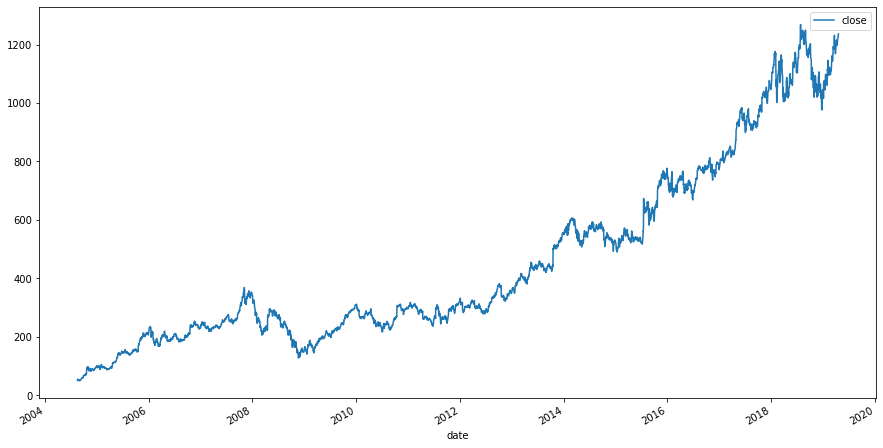

In [111]:
df.plot(use_index=True,figsize=(15,8))

In [112]:
# transform scale
data = df.values
# data = X.reshape(len(X), 1)
# scaler = MinMaxScaler(feature_range=(0, 1))
# scaler = scaler.fit(data)
# data = scaler.transform(data)
# data[-10:]

In [113]:
def split_sequence(sequence, n_steps_in, n_steps_out): 
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [114]:
STEPS_IN = 30
STEPS_OUT = 7
X,y = split_sequence(data, STEPS_IN, STEPS_OUT)


In [115]:
print(X.shape)
print(y.shape)
# for i in range(len(X)):
#   print(X[i], y[i])

(3656, 30, 1)
(3656, 7, 1)


In [116]:
# reshape from [samples, timesteps] into [samples, timesteps, features]

In [117]:
n_features = 1
X_transformed = X.reshape((X.shape[0], X.shape[1], n_features))
X_transformed.shape

(3656, 30, 1)

### Model Definition

In [118]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features))) 
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True)) 
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

In [119]:
# fit model
model.fit(X, y, epochs=100, verbose=1)

Epoch 1/100
3656/3656 [==============================] - 2s 620us/step - loss: 107314.6899
Epoch 2/100
3656/3656 [==============================] - 2s 456us/step - loss: 66673.9224
Epoch 3/100
3656/3656 [==============================] - 2s 451us/step - loss: 28864.5008
Epoch 4/100
3656/3656 [==============================] - 2s 452us/step - loss: 57662.3562
Epoch 5/100
3656/3656 [==============================] - 2s 454us/step - loss: 19744.1356
Epoch 6/100
3656/3656 [==============================] - 2s 456us/step - loss: 99639.4554
Epoch 7/100
3656/3656 [==============================] - 2s 456us/step - loss: 654159.7301
Epoch 8/100
3656/3656 [==============================] - 2s 459us/step - loss: 25187.0011
Epoch 9/100
3656/3656 [==============================] - 2s 458us/step - loss: 3115.6756
Epoch 10/100
3656/3656 [==============================] - 2s 456us/step - loss: 2222.3016
Epoch 11/100
3656/3656 [==============================] - 2s 460us/step - loss: 8138.3585
Epoch 12/

3656/3656 [==============================] - 2s 464us/step - loss: 1174.9465
Epoch 93/100
3656/3656 [==============================] - 2s 464us/step - loss: 1117.3944
Epoch 94/100
3656/3656 [==============================] - 2s 465us/step - loss: 1194.9731
Epoch 95/100
3656/3656 [==============================] - 2s 465us/step - loss: 1212.0412
Epoch 96/100
3656/3656 [==============================] - 2s 463us/step - loss: 1211.4555
Epoch 97/100
3656/3656 [==============================] - 2s 462us/step - loss: 1172.0876
Epoch 98/100
3656/3656 [==============================] - 2s 469us/step - loss: 1125.9441
Epoch 99/100
3656/3656 [==============================] - 2s 465us/step - loss: 1114.2190
Epoch 100/100
3656/3656 [==============================] - 2s 466us/step - loss: 1156.7744


In [128]:
x_input = data[-67:-37]
x_input = x_input.reshape((1, 30, 1))
y = data[-37:-30]
y_pred = model.predict(x_input, verbose=0).ravel()
mse = np.mean((y - y_pred)**2)

In [129]:
print(y_pred)
print(y)

[1105.3899 1106.7301 1100.4396 1109.8408 1111.1344 1114.2983 1116.3677]
[[1116.05004883]
 [1119.92004395]
 [1140.98999023]
 [1147.80004883]
 [1162.0300293 ]
 [1157.85998535]
 [1143.30004883]]


In [130]:
# range_y = list(range(0,7))

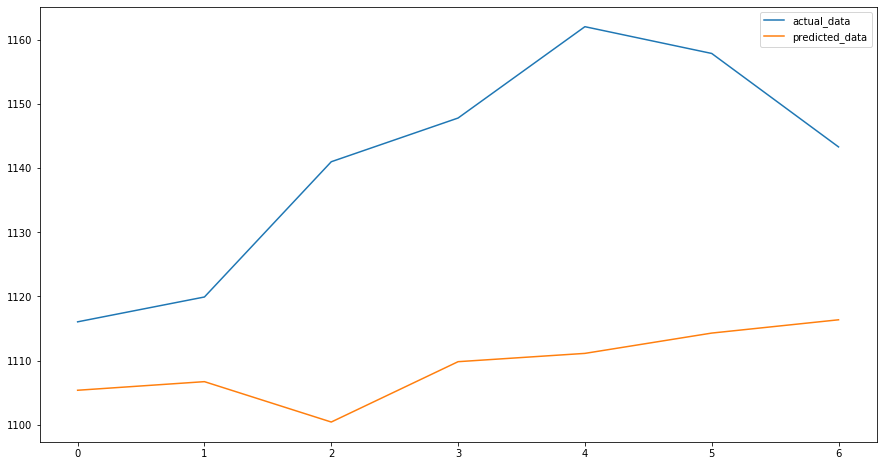

In [131]:
plt.figure(figsize=(15,8))
plt.plot(y, label='actual_data')
plt.plot(y_pred, label='predicted_data')
plt.legend()
plt.show()